In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from skimage.feature import hog
from sklearn.linear_model import Ridge
import os
import sys
import cv2
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.model_selection import train_test_split

#set route
sys.path.insert(1, 'C:/Users/dexte/github/RoboSkin/Code/')
import RoboSkin as sk
file="C:/Users/dexte/github/RoboSkin/Assets/Video demos/"

#load dataset
names=["north.avi","north-east.avi","east.avi","south-east.avi","south.avi","south-west.avi","west.avi","north-west.avi"]
y_=[[1,1,
    0,0],[1,1,
          0,1],[0,1,
                0,1],[0,1,
                      1,1],[0,0,
                            1,1],[1,0,
                                  1,1],[1,0,
                                        1,0],[1,1,
                                              1,0]]

## Dataset creator

In [15]:
class dataset:
    def __init__(self,names=["flat_detection.avi","edge_detection.avi","flat_slip_detection.avi","soft_detection.avi","flat_slip_detection_paper.avi","nothing.avi"]):
        self.path="C:/Users/dexte/github/RoboSkin/Assets/Video demos/"
        self.names=names
        self.SIZE=0.3

    def gen_image_data(self,y_labels=[],scale=False,size=1,show=True,skip=4):
        BIG_DATA_X=None
        BIG_DATA_y=None
        assert len(y_labels)>=len(self.names),"Incorrect length of labels"
        for j,name in enumerate(self.names):
            counter=0
            skin=sk.Skin(videoFile=self.path+name)#videoFile=path+"Movement4.avi") #load skin object using demo video
            cap = cv2.VideoCapture(self.path+name)
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            skin.sharpen=False #falsify the sharpness if recorded with sharpness
            X=[]
            y=[] #label as [edge surface soft hard slippery]
            SPLIT=20
            past_Frame=skin.getBinary()
            OOO=past_Frame.copy()
            image=np.zeros_like(past_Frame)
            for i in range(0,length,skip): #lop through all
                im=skin.getBinary()
                #get pressure map
                image,grid=skin.getForceGrid(im,SPLIT,image=image,threshold=40,degrade=20,past=OOO)
                frame=im.copy()
                frame = np.uint8(frame)
                #current = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #
                frame = cv2.adaptiveThreshold(
                        frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 1
                    )
                kernel = np.ones((2, 2), np.uint8)
                frame = cv2.erode(frame, kernel, iterations=1)
                diff=np.sum(grid)/(SPLIT*SPLIT)
                # Calculate the new dimensions based on the scale factor
                new_width = int(image.shape[1] * size)
                new_height = int(image.shape[0] * size)

                # Use cv2.resize() to resize the image with area interpolation
                frame = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

                if diff>1.7: #significant contact
                    #all_frames=np.zeros(())
                    X.append(np.array(frame.flatten())) #store temporal element
                    y.append(y_labels[j])
                    counter+=1

            if type(BIG_DATA_y)==type(None):
                BIG_DATA_y=np.array(y.copy())
                BIG_DATA_X=np.array(X.copy())
            else:
                BIG_DATA_y= np.concatenate((np.array(y.copy()),BIG_DATA_y))
                BIG_DATA_X= np.concatenate((np.array(X.copy()),BIG_DATA_X))
            if show: print(name,"Length:",counter,"/",str(length),"X-size:",BIG_DATA_X.shape)
        print("Completed creation",np.average(BIG_DATA_X),np.std(BIG_DATA_X))
        if scale:
            """scaler1 = preprocessing.StandardScaler().fit(a)
            a = scaler1.transform(a)"""
            BIG_DATA_X=(BIG_DATA_X-np.average(BIG_DATA_X))/np.std(BIG_DATA_X)
        return BIG_DATA_X,BIG_DATA_y
    


In [3]:
d=dataset(names)
x,y=d.gen_image_data(y_,False,1,True)
x, x_test, y, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Length",len(x))

north.avi Length: 117 / 541 X-size: (117, 307200)
north-east.avi Length: 40 / 359 X-size: (157, 307200)
east.avi Length: 38 / 461 X-size: (195, 307200)
south-east.avi Length: 36 / 375 X-size: (231, 307200)
south.avi Length: 60 / 408 X-size: (291, 307200)
south-west.avi Length: 38 / 484 X-size: (329, 307200)
west.avi Length: 44 / 400 X-size: (373, 307200)
north-west.avi Length: 40 / 386 X-size: (413, 307200)
Completed creation 4.277087219090497 19.02681725851341
Length 330


## Regression with TacTip

In [6]:
clf = Ridge(alpha=1.0)
clf.fit(x, y)
coords=clf.predict(x)
coords=np.round(coords,0)
error=np.sum(np.abs(coords-y))/(4*len(coords))
print("Train Error",round(error*100,2),"%")

Train Error 1.89 %


In [8]:
coords=clf.predict(x_test)
coords=np.round(coords,0)
error=np.sum(np.abs(coords-y_test))/(4*len(coords))
print("Test Error",round(error*100,2),"%","Accuracy",100-round(error*100,2),"%")

Test Error 4.22 % Accuracy 95.78 %


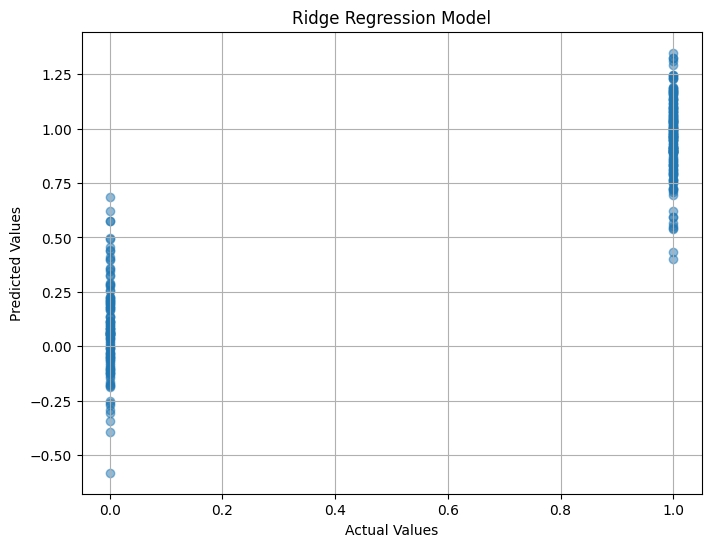

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, coords, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression Model')
plt.grid(True)
plt.show()

### Experiment with scale

In [10]:
a=[]
t=[]
for i in np.arange(0.01,1,0.01):
    d=dataset(names)
    x,y=d.gen_image_data(y_,False,size=i,show=False,skip=2)
    print("Dimention",x.shape[1])
    x, x_test, y, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    clf = Ridge(alpha=1.0)
    clf.fit(x, y)
    coords=clf.predict(x)
    coords=np.round(coords,0)
    error=np.sum(np.abs(coords-y))/(4*len(coords))
    t.append(error)
    print("Train Error",round(error*100,2),"%")
    coords=clf.predict(x_test)
    coords=np.round(coords,0)
    error=np.sum(np.abs(coords-y_test))/(4*len(coords))
    print("Test Error",round(error*100,2),"%","Accuracy",100-round(error*100,2),"%")
    a.append(error)
    

Completed creation 3.9933212077541813 7.716017263347604
Dimention 24
Train Error 14.55 %
Test Error 14.38 % Accuracy 85.62 %
Completed creation 3.993321155468839 11.432849397137382
Dimention 108
Train Error 5.96 %
Test Error 5.96 % Accuracy 94.04 %
Completed creation 3.9933208134196065 12.656303844169958
Dimention 266
Train Error 4.39 %
Test Error 4.92 % Accuracy 95.08 %
Completed creation 3.9933207962421426 14.003907015796848
Dimention 475
Train Error 3.94 %
Test Error 4.66 % Accuracy 95.34 %
Completed creation 3.9933207516632394 15.368968178908359
Dimention 768
Train Error 3.94 %
Test Error 4.66 % Accuracy 95.34 %
Completed creation 3.9933208167786813 16.180671236186754
Dimention 1064
Train Error 3.94 %
Test Error 4.66 % Accuracy 95.34 %
Completed creation 3.9933210050358445 16.35774804812358
Dimention 1452
Train Error 3.94 %
Test Error 4.66 % Accuracy 95.34 %
Completed creation 3.9933207311927275 16.92899422992627
Dimention 1938
Train Error 3.94 %
Test Error 4.66 % Accuracy 95.34 %


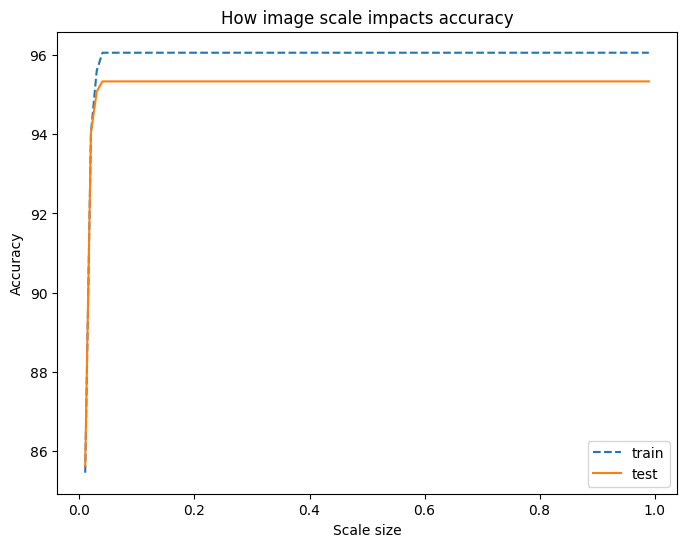

99

In [17]:
plt.figure(figsize=(8, 6))
plotted=(1-np.array(a))*100
trained=(1-np.array(t))*100
plt.plot(np.arange(0.01,1,0.01),trained,"--",label="train")
plt.plot(np.arange(0.01,1,0.01),plotted,label="test")
plt.title("How image scale impacts accuracy")
plt.xlabel("Scale size")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()
len(plotted)

In [13]:
np.save("C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/TacTip vs pressure/accuracyTrain",trained)
np.save("C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/TacTip vs pressure/accuracyTest",plotted)

In [4]:
d=dataset(names)
x1,y1=d.gen_image_data(y_,False,size=0.05,show=False,skip=2)
x2,y2=d.gen_image_data(y_,False,size=1,show=False,skip=2)



Completed creation 3.9933207516632394 15.368968178908359
Completed creation 3.9933208409209158 18.71409456322868


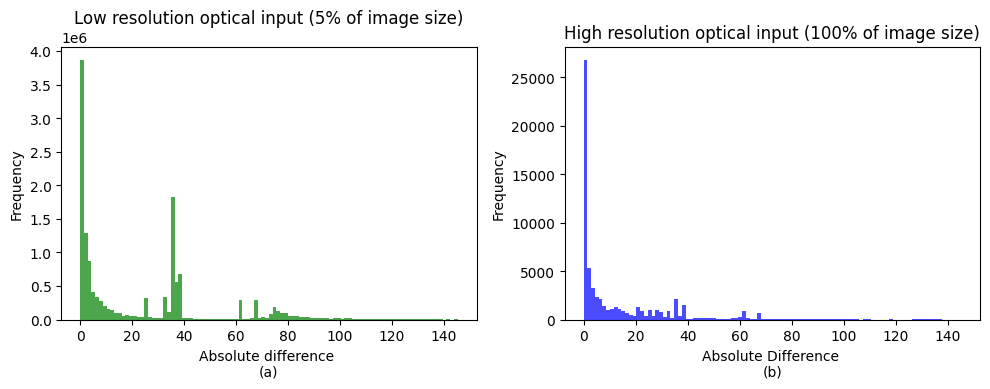

In [25]:
diff_x1=np.abs(np.diff(x1,axis=0))
diff_x2=np.abs(np.diff(x2,axis=0))

abs_diff_flat1 = diff_x1.flatten()
abs_diff_flat2 = diff_x2.flatten()

abs_diff_flat1=abs_diff_flat1[abs_diff_flat1!=0]
abs_diff_flat2=abs_diff_flat2[abs_diff_flat2!=0]
#normalize
#abs_diff_flat1=(abs_diff_flat1-np.min(abs_diff_flat1))/(np.max(abs_diff_flat1)-np.min(abs_diff_flat1))
#abs_diff_flat2=(abs_diff_flat2-np.min(abs_diff_flat2))/(np.max(abs_diff_flat2)-np.min(abs_diff_flat2))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the histogram for the original data
ax1.hist(abs_diff_flat2, bins=100, color='green', alpha=0.7)
ax1.set_xlabel('Absolute difference \n(a)')
ax1.set_ylabel('Frequency')
ax1.set_title('Low resolution optical input (5% of image size)')

# Plot the histogram for the absolute differences
ax2.hist(abs_diff_flat1, bins=100, color='blue', alpha=0.7)
ax2.set_xlabel('Absolute Difference \n(b)')
ax2.set_ylabel('Frequency')
ax2.set_title('High resolution optical input (100% of image size)')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()